<a href="https://colab.research.google.com/github/Sumithrapm/Classify_Side_Effects/blob/main/TCS_Classify_side_effects_of_Drugs_by_demographic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Step 1 - Importing libraries and loading datafile***

In [ ]:
 pip install sidetable

In [ ]:

import numpy as np
import pandas as pd
import sidetable as stb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv("/content/drive/MyDrive/webmd.csv")


Mounted at /content/drive


### Checking basic details

In [ ]:
df.head(2)

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1


In [ ]:
df.shape

(362806, 12)

In [ ]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [ ]:
df.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


In [ ]:
df.apply(lambda x: len(x.unique()))

Age                  12
Condition          1806
Date               4524
Drug               7093
DrugId             6572
EaseofUse             7
Effectiveness         7
Reviews          250168
Satisfaction          7
Sex                   3
Sides              1651
UsefulCount         148
dtype: int64

In [ ]:
#Print frequency of categories

cata_feature=[feature for feature in df.columns if df[feature].dtypes=='O']
cata_feature = [x for x in cata_feature if x  in ['Age', 'Sex']]
for col in cata_feature:
    print('\nFrequency of Categories for varible %s'%col)
    print('-'*40)
    print(df[col].value_counts())


Frequency of Categories for varible Age
----------------------------------------
45-54         80043
55-64         75136
35-44         55011
25-34         49718
65-74         41216
19-24         24230
75 or over    15226
              12202
13-18          7045
7-12           1644
3-6             838
0-2             497
Name: Age, dtype: int64

Frequency of Categories for varible Sex
----------------------------------------
Female    238226
Male       98043
           26537
Name: Sex, dtype: int64


## Checking Null values

In [ ]:
df = df.replace(" ",np.nan)
df.isnull().sum()

Age              12202
Condition           43
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          41861
Satisfaction         0
Sex              26537
Sides            17460
UsefulCount          0
dtype: int64

## Imputing null values

In [ ]:
list1=['Period','Birth','Periods',"Birth Control","Uterus","Endometriosis","Breast","Ovary","menopausal","Vagina","Abortion","Pregnancy","Ovarian","Female","Cervix","Woman","Cervical"]
df.loc[df['Condition'].isin(list1),'Sex']="Female"
df.loc[df['Condition'].isin(['Prostate']),'Sex']='Male'

In [ ]:
for col in ["Age", "Condition", "Sex","Sides"]:
  df = df[(df[col].astype(bool) & df[col].notnull())]

In [ ]:
df=df.drop(['Reviews','Date'],axis=1)

##Checking Outliers

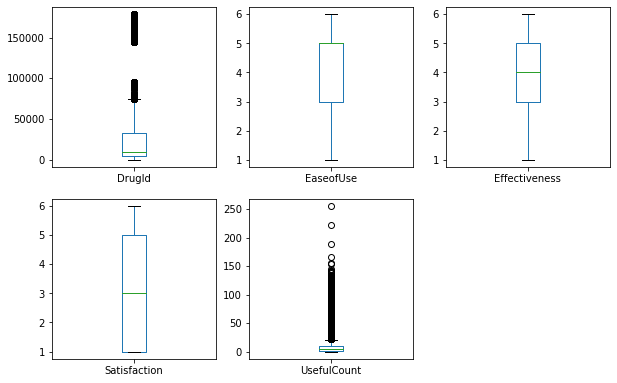

In [ ]:
df.plot(kind='box',subplots=True,layout=(3,3),sharex=False,sharey= False,figsize=(10,10));

In [ ]:
drugs = {}
for drugid, drug in df[["DrugId", "Drug"]].itertuples(index=False):
    drugs.setdefault(drugid, set()).add(drug)
drugs = {k:v for k,v in drugs.items()}
count=0
drugs_with_more_names = {k:v for k,v in drugs.items() if len(v) > 1}
for k,v in dict(drugs_with_more_names.items()).items():
    print(f"{k}: {(v)}")
    count=count+1
    if count==5:
      break

167493: {'lynparza tablet', 'lynparza'}
7286: {'loteprednol etabonate ointment', 'loteprednol etabonate drops, suspension', 'loteprednol etabonate drops, gel'}
7319: {'lotemax ointment', 'lotemax drops, gel'}
164437: {'lorcaserin tablet', 'lorcaserin tablet, extended release 24 hr'}
8892: {'lorazepam concentrate', 'lorazepam'}


WE can conclude Drug has more values than DrugId is that some drugs are sold is different forms, like cream, pill, gel, etc. so we go with DrugId .

In [ ]:
df.insert(0, "Patient_Id", range(1, 1+ len(df)))
new_df = pd.DataFrame(df.Sides.str.split(',').tolist(),index=df.Patient_Id).stack()
new_df = new_df.reset_index([0, 'Patient_Id'])
new_df.columns = ['Patient_Id','Side_Effects']
new_df.head(2)


,Patient_Id,Side_Effects
0,1,Drowsiness
1,1,dizziness


In [ ]:
new_df.shape

(1946931, 2)

In [ ]:
def convert_lower(text):
   return text.lower()
new_df['Side_Effects'] = new_df['Side_Effects'].apply(convert_lower)

In [ ]:
store_patterns =[
              
    (new_df['Side_Effects'].str.contains('abdominal', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('acne', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('vaginal', case=False, regex=False), 'menstrual changes'),
    (new_df['Side_Effects'].str.contains('bloating', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('breast', case=False, regex=False), 'breast changes'),
    (new_df['Side_Effects'].str.contains('constipation', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('diarrhea', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('dizziness', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('eye', case=False, regex=False),'eye/vision problem'),
    (new_df['Side_Effects'].str.contains('dry mouth', case=False, regex=False), 'mouth issues'),
    (new_df['Side_Effects'].str.contains('flu -', case=False, regex=False), 'fever'),
    (new_df['Side_Effects'].str.contains('urin', case=False, regex=False), 'urination problem'),
    (new_df['Side_Effects'].str.contains('hair', case=False, regex=False), 'hair loss/problems'),
    (new_df['Side_Effects'].str.contains('headache', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('heartburn', case=False, regex=False), 'heartburn'),
    (new_df['Side_Effects'].str.contains('flush', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('itching', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('joint', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('taste', case=False, regex=False), 'mouth issues'),
    (new_df['Side_Effects'].str.contains('mouth', case=False, regex=False), 'mouth issues'),
    (new_df['Side_Effects'].str.contains('muscle', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('ear', case=False, regex=False), 'earache/ringing'),
    (new_df['Side_Effects'].str.contains('skin', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('sneez', case=False, regex=False), 'sneezing'),
    (new_df['Side_Effects'].str.contains('throat', case=False, regex=False), 'sore throat'),
    (new_df['Side_Effects'].str.contains('stomach', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('sweat', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('sleep', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('vomiting', case=False, regex=False), 'nausea'),
    (new_df['Side_Effects'].str.contains('nausea', case=False, regex=False), 'nausea'),
    (new_df['Side_Effects'].str.contains('rash', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('bump', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('vision', case=False, regex=False), 'eye/vision problem'),
    (new_df['Side_Effects'].str.contains('weakness', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('weight', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('bowel', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('nosebleed', case=False, regex=False), 'nosebleeds'),
    (new_df['Side_Effects'].str.contains('nose', case=False, regex=False), 'runny nose'),
    (new_df['Side_Effects'].str.contains('burning', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('burping', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('concentrat', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('drowsiness', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('fever', case=False, regex=False), 'fever'),
    (new_df['Side_Effects'].str.contains('bladder', case=False, regex=False), 'urination problem'),
    (new_df['Side_Effects'].str.contains('appetite', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('itching', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('shak', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('numb', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('peeling', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('restlessness', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('injection', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('tired', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('yawn', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('bruising', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('eyelid', case=False, regex=False), 'eye/vision problem'),
    (new_df['Side_Effects'].str.contains('crust', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('sex', case=False, regex=False), 'menstrual changes'),
    (new_df['Side_Effects'].str.contains('hoarseness', case=False, regex=False), 'hoarseness'),
    (new_df['Side_Effects'].str.contains('thirst', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('gas', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('irrita', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('menstrual', case=False, regex=False), 'menstrual changes'),
    (new_df['Side_Effects'].str.contains('mood', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('nerousness', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('lightheadedness', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('sting', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('coordinat', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('dryness', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('staining', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('redness', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('swelling', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('tingling', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('pimple', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('allergy', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('soreness', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('small soreness', case=False, regex=False), 'allergy'),
    (new_df['Side_Effects'].str.contains('termor', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('walking', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('well-being', case=False, regex=False), 'euphoria'),
    (new_df['Side_Effects'].str.contains('rectal', case=False, regex=False), 'rectal pain/burning/itching'),
    (new_df['Side_Effects'].str.contains('sleep', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('pain', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('body ache', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('ache', case=False, regex=False), 'pain'),
    (new_df['Side_Effects'].str.contains('excit', case=False, regex=False), 'euphoria'),
    (new_df['Side_Effects'].str.contains('gas', case=False, regex=False), 'stomach upset'),
    (new_df['Side_Effects'].str.contains('nervousness', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('anxiety', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('unsteadiness', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('dreams', case=False, regex=False), 'drowsiness'),
    (new_df['Side_Effects'].str.contains('saliva', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('fatigue', case=False, regex=False), 'dizziness'),
    (new_df['Side_Effects'].str.contains('impotence', case=False, regex=False), 'drowsiness'),


]
    
    

In [ ]:
store_criteria, store_values = zip(*store_patterns)
new_df['side_Effect'] = np.select(store_criteria, store_values, None)
new_df['side_Effect'] = new_df['side_Effect'].combine_first(new_df['Side_Effects'])
new_df=new_df.drop(["Side_Effects"],axis=1)

### Merging Datasets

In [ ]:
df=df.drop(['Sides','UsefulCount'],axis=1)
df = pd.merge(df, new_df, on="Patient_Id")

### Drop Duplicates

In [ ]:
df.drop_duplicates(subset=["Patient_Id",	"Age",	"Condition",	"Drug",	"DrugId",	"EaseofUse",	"Effectiveness",	"Satisfaction",	"Sex"],keep='first',inplace=True)


In [ ]:
df.stb.freq(['side_Effect']).head(10)

,side_Effect,count,percent,cumulative_count,cumulative_percent
0,nausea,119208,37.669811,119208,37.669811
1,dizziness,53682,16.963549,172890,54.633360
2,drowsiness,45896,14.503168,218786,69.136528
3,stomach upset,43493,13.743818,262279,82.880346
4,allergy,16223,5.126479,278502,88.006826
5,pain,14261,4.506486,292763,92.513312
6,mouth issues,5362,1.694396,298125,94.207707
7,urination problem,4386,1.385979,302511,95.593686
8,eye/vision problem,2462,0.777994,304973,96.371680
9,hot flashes,2095,0.662021,307068,97.033701


In [ ]:
df.apply(lambda x: len(x.unique()))

Patient_Id       316455
Age                  11
Condition          1640
Drug               5280
DrugId             4773
EaseofUse             6
Effectiveness         6
Satisfaction          6
Sex                   2
side_Effect          71
dtype: int64

In [ ]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.85,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      print(s)
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column


#Call the function with a default threshold of 85%
df['side_Effect'],new_category_list=cumulatively_categorise(df['side_Effect'],return_categories_list=True)

278502


In [ ]:
df['side_Effect'].describe()

count     316455
unique         6
top       nausea
freq      119208
Name: side_Effect, dtype: object

In [ ]:
df['side_Effect'].value_counts()

nausea           119208
dizziness         53682
drowsiness        45896
stomach upset     43493
Other             37953
allergy           16223
Name: side_Effect, dtype: int64

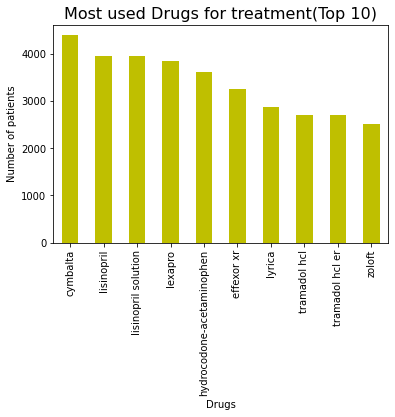

In [ ]:
# lets check the list of most used Drugs for treatment (top 10)
df['Drug'].value_counts().head(10).plot(kind='bar',color='y')
plt.title('Most used Drugs for treatment(Top 10)',fontsize=16)
plt.xlabel("Drugs")
plt.ylabel('Number of patients')
#plt.rcParams['figure.figsize'] = (8,7)
plt.show()

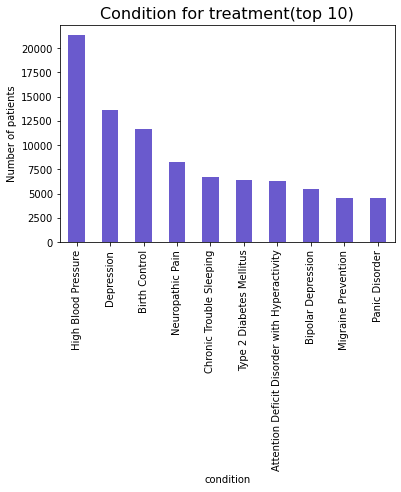

In [ ]:
# lets check the various conditions the medicine cures (top 10) 

df['Condition'].value_counts().transpose()[2:12].plot(kind='bar',color='slateblue')
plt.title("Condition for treatment(top 10)",fontsize=16)
plt.rcParams['figure.figsize'] = (4,8)
plt.xlabel('condition')
plt.ylabel('Number of patients')
plt.show()

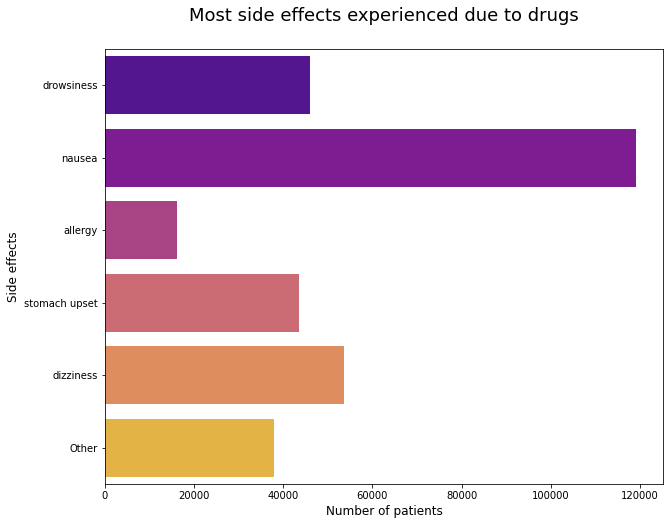

In [ ]:
plt.subplots(figsize=(10,8))
plot = sns.countplot(y='side_Effect',data=df,palette=sns.color_palette('plasma'))
plt.xlabel('Number of patients',fontsize=12)
plt.ylabel('Side effects',fontsize=12)
plt.title('Most side effects experienced due to drugs',fontsize=18,y=1.05)
plt.show()

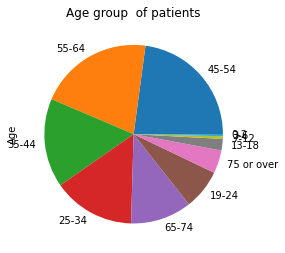

In [ ]:
# lets check the Age group  of patients
df['Age'].value_counts().plot(kind='pie')
plt.title('Age group  of patients')
plt.rcParams['figure.figsize'] = (10,10)
plt.show()

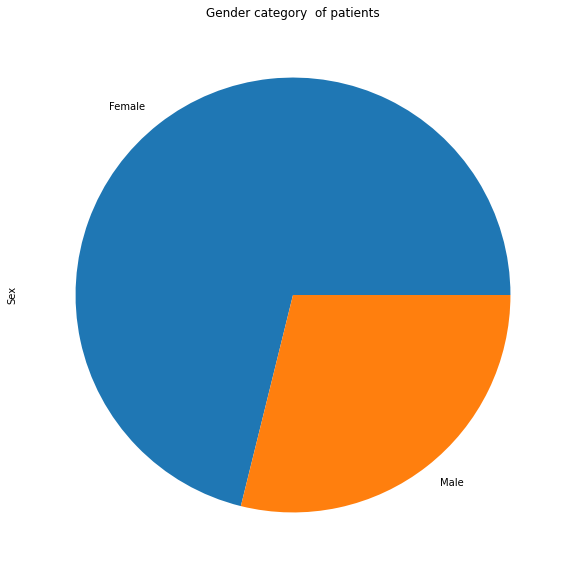

In [ ]:
# lets check the Gender category of patients
df['Sex'].value_counts().plot(kind='pie')
plt.title('Gender category  of patients')
plt.rcParams['figure.figsize'] = (6,6)
plt.show()

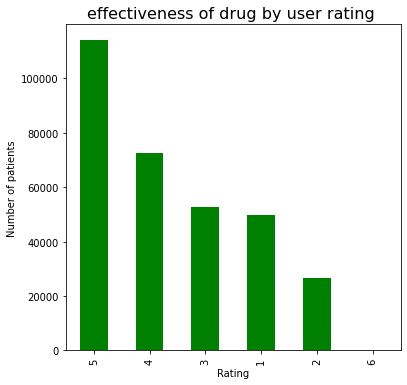

In [ ]:
# lets check the effectiveness of drug by user rating 

df['Effectiveness'].value_counts().head(10).plot(kind='bar',color="g")
plt.title("effectiveness of drug by user rating ",fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Number of patients')
plt.show()

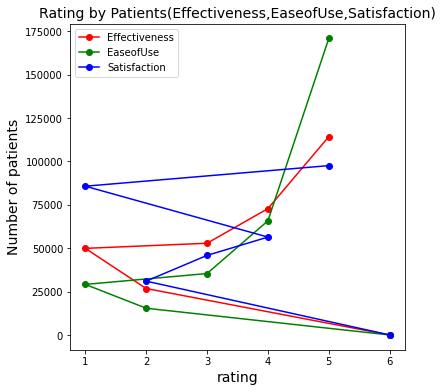

In [ ]:
df['Effectiveness'].value_counts().plot(kind='line',color='red', marker='o',legend="Effectiveness")
df['EaseofUse'].value_counts().plot(kind='line',color='green', marker='o',legend="EaseofUse")
df['Satisfaction'].value_counts().plot(kind='line',color='blue', marker='o',legend='Satisfaction')
plt.title('Rating by Patients(Effectiveness,EaseofUse,Satisfaction)', fontsize=14)
plt.xlabel('rating', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)

plt.show()

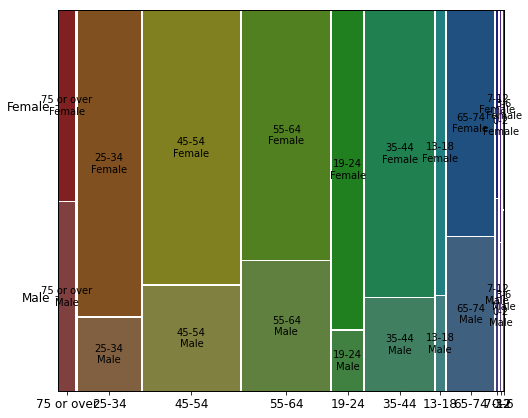

In [ ]:

# mosaic plot from statsmodels. Which can also give statistical highlighting for the variances.

from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['figure.figsize'] = (8,7)
plt.rcParams['font.size'] = 12.0
mosaic(df, ['Age', 'Sex']);

In [ ]:
# put target into a seperate columns

target = df.pop('side_Effect')


In [ ]:
# lets convert categorical data to numeric

#Label encoding
cols = ['Age','Condition',	'Drug',	'Sex']
label_encoder = preprocessing.LabelEncoder()
df['Age']= label_encoder.fit_transform(df['Age']) 
df['Condition']= label_encoder.fit_transform(df['Condition'])
df['Drug']= label_encoder.fit_transform(df['Drug']) 

#One hot encoding
df['Sex']=pd.get_dummies(df['Sex'])

#Label encoding target column
target =  label_encoder.fit_transform(target)
df.head()

,Patient_Id,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex
0,1,10,1456,4,146724,5,5,5,0
7,2,3,394,4,146724,5,5,5,1
14,3,3,222,5105,163180,5,5,2,1
21,4,6,515,5105,163180,5,5,5,1
28,5,3,51,5105,163180,4,2,2,1


In [ ]:
#for feature selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

#apply feature selection
feature_sel_model= SelectFromModel(Lasso(alpha=0.005,random_state=0))
feature_sel_model.fit(df,target)


feature_sel_model.get_support()

array([False,  True,  True, False, False,  True, False,  True,  True])

In [ ]:
#Printing total number of selected features
select_feat=df.columns[(feature_sel_model.get_support())]

#printing stastistics
print('total features: {} ' .format((df.shape[1]) ))
print('selected features: {} ' .format(len(select_feat) ))
print('features with coefficients shrank to zero: {} ' .format(np.sum(feature_sel_model.estimator_.coef_) ))

total features: 9 
selected features: 5 
features with coefficients shrank to zero: -0.08414580725404525 


In [ ]:
#Chi-square test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features = SelectKBest(score_func=chi2,k="all")
fit = best_features.fit(df,target)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(df.columns)
feature_scores = pd.concat([df_columns,df_scores],axis=1)
feature_scores.columns = ['Feature','Score']
feature_scores.sort_values('Score',ascending=True) #p-value

,Feature,Score
8,Sex,2.054303e+02
6,Effectiveness,4.287306e+02
5,EaseofUse,4.533867e+02
7,Satisfaction,6.684590e+02
1,Age,4.219721e+03
2,Condition,5.074231e+05
3,Drug,6.819269e+06
0,Patient_Id,3.011012e+08
4,DrugId,7.284095e+08


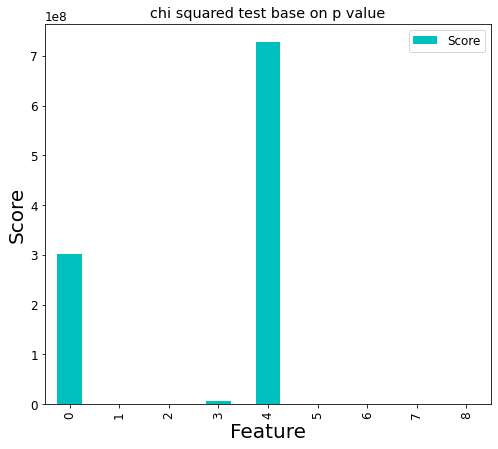

In [ ]:
feature_scores.plot(kind="bar",color="c")
plt.xlabel("Feature",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("chi squared test base on p value")
plt.show()

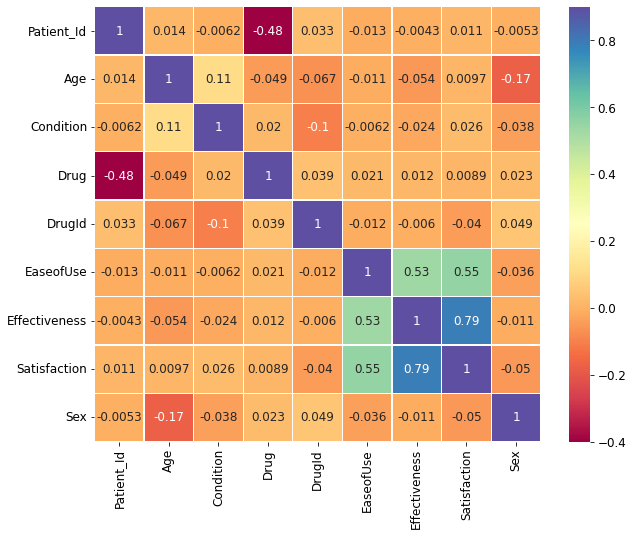

In [ ]:
#dropping higly correlated features
correlated_features = set()
correlation_matrix=df.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(correlation_matrix,vmin=-.4,vmax=0.9,annot=True,linewidths=0.2,cmap="Spectral");

In [ ]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [ ]:
correlated_features

{'Effectiveness', 'Satisfaction'}

In [ ]:
df=df.drop(columns=correlated_features)
df=df.drop(columns=["Patient_Id","EaseofUse","Drug"])

In [ ]:
df

,Age,Condition,DrugId,Sex
0,10,1456,146724,0
7,3,394,146724,1
14,3,222,163180,1
21,6,515,163180,1
28,3,51,163180,1
...,...,...,...,...
1946886,3,1447,144470,1
1946895,7,1447,144470,1
1946904,3,1447,144470,1
1946913,7,1447,144470,0


Class=3, n=45896 (14.503%)
Class=4, n=119208 (37.670%)
Class=1, n=16223 (5.126%)
Class=5, n=43493 (13.744%)
Class=2, n=53682 (16.964%)
Class=0, n=37953 (11.993%)


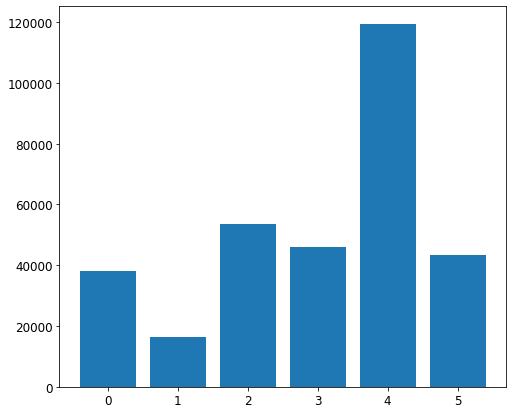

In [ ]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=3, n=119208 (16.667%)
Class=4, n=119208 (16.667%)
Class=1, n=119208 (16.667%)
Class=5, n=119208 (16.667%)
Class=2, n=119208 (16.667%)
Class=0, n=119208 (16.667%)


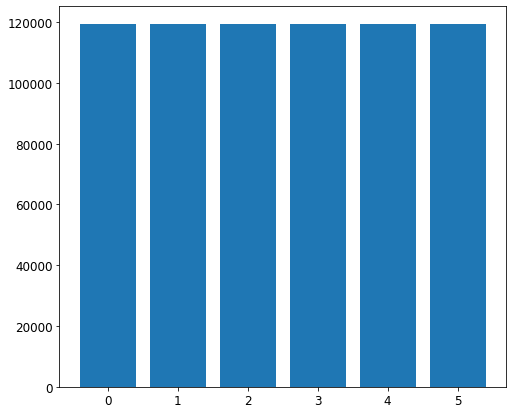

In [ ]:

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
df,target= oversample.fit_resample(df,target)
# summarize distribution
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df=MinMaxScaler().fit_transform(df)
df

array([[1.        , 0.88834655, 0.82205128, 0.        ],
       [0.3       , 0.24039048, 0.82205128, 1.        ],
       [0.3       , 0.13544844, 0.91425002, 1.        ],
       ...,
       [0.7       , 0.976205  , 0.02974496, 0.        ],
       [0.3       , 0.6680903 , 0.02596871, 0.        ],
       [0.5       , 0.92861501, 0.43470003, 0.        ]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target,random_state=14,test_size=.2)

              precision    recall  f1-score   support

           0       0.28      0.27      0.27     23760
           1       0.27      0.22      0.24     23986
           2       0.23      0.58      0.33     23784
           3       0.18      0.03      0.06     23942
           4       0.21      0.31      0.25     23790
           5       0.00      0.00      0.00     23788

    accuracy                           0.23    143050
   macro avg       0.19      0.24      0.19    143050
weighted avg       0.19      0.23      0.19    143050



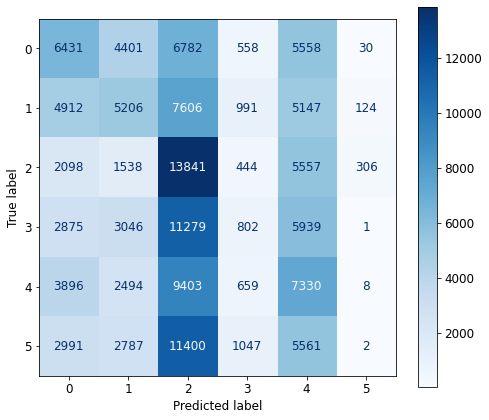

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,precision_score,recall_score,f1_score,accuracy_score

from sklearn.linear_model import LogisticRegression
#Logistic Regression
logreg = LogisticRegression()
model=logreg.fit(X_train, y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))  

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     23760
           1       0.92      0.93      0.92     23986
           2       0.95      0.95      0.95     23784
           3       0.94      0.94      0.94     23942
           4       0.94      0.90      0.92     23790
           5       0.93      0.91      0.92     23788

    accuracy                           0.93    143050
   macro avg       0.93      0.93      0.93    143050
weighted avg       0.93      0.93      0.93    143050



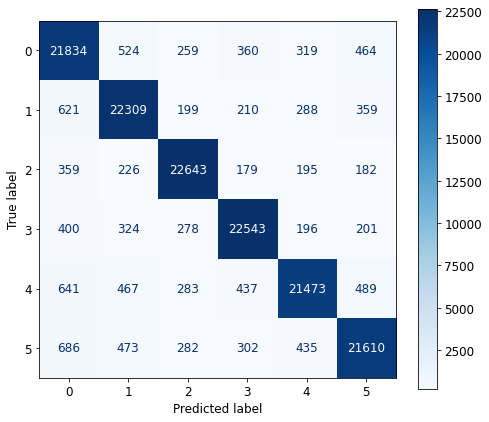

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=6).fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))  

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     23760
           1       0.98      0.98      0.98     23986
           2       0.99      0.99      0.99     23784
           3       0.99      0.99      0.99     23942
           4       0.99      0.98      0.99     23790
           5       0.98      0.98      0.98     23788

    accuracy                           0.98    143050
   macro avg       0.98      0.98      0.98    143050
weighted avg       0.98      0.98      0.98    143050



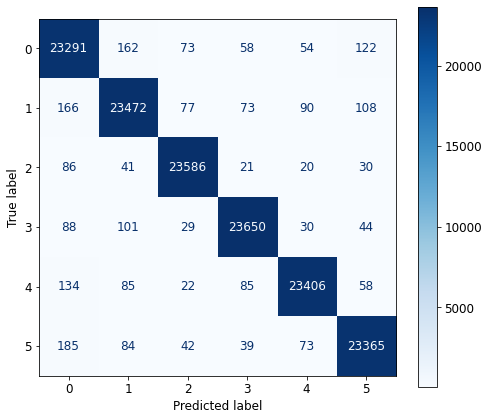

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
model=dtree.fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23760
           1       0.98      0.98      0.98     23986
           2       0.99      0.99      0.99     23784
           3       0.98      0.98      0.98     23942
           4       0.99      0.97      0.98     23790
           5       0.98      0.98      0.98     23788

    accuracy                           0.98    143050
   macro avg       0.98      0.98      0.98    143050
weighted avg       0.98      0.98      0.98    143050



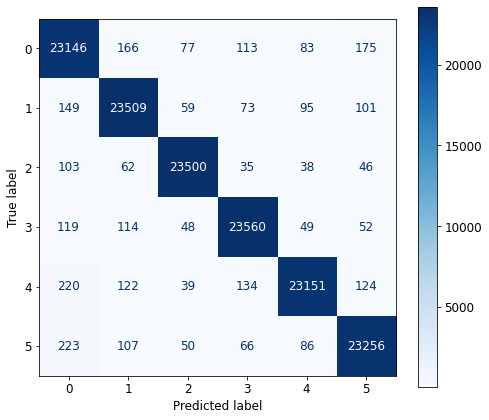

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest Classifier
randomForest= RandomForestClassifier(n_estimators=100)
model=randomForest.fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72     23760
           1       0.74      0.77      0.75     23986
           2       0.85      0.81      0.83     23784
           3       0.78      0.83      0.80     23942
           4       0.84      0.77      0.80     23790
           5       0.75      0.69      0.72     23788

    accuracy                           0.77    143050
   macro avg       0.77      0.77      0.77    143050
weighted avg       0.77      0.77      0.77    143050



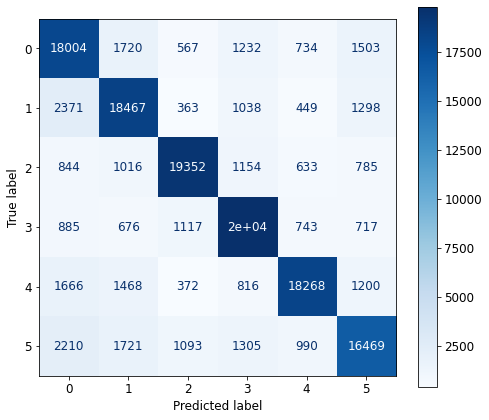

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
model=gb_model.fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.21      0.18      0.20     23760
           1       0.22      0.19      0.21     23986
           2       0.21      0.72      0.32     23784
           3       0.02      0.00      0.00     23942
           4       0.20      0.15      0.17     23790
           5       0.00      0.00      0.00     23788

    accuracy                           0.21    143050
   macro avg       0.14      0.21      0.15    143050
weighted avg       0.14      0.21      0.15    143050



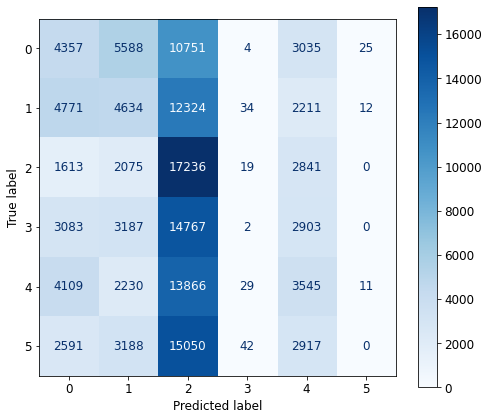

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
model=clf.fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))


              precision    recall  f1-score   support

           0       0.61      0.72      0.67     23760
           1       0.67      0.70      0.68     23986
           2       0.81      0.76      0.78     23784
           3       0.70      0.76      0.73     23942
           4       0.82      0.69      0.75     23790
           5       0.69      0.62      0.66     23788

    accuracy                           0.71    143050
   macro avg       0.72      0.71      0.71    143050
weighted avg       0.72      0.71      0.71    143050



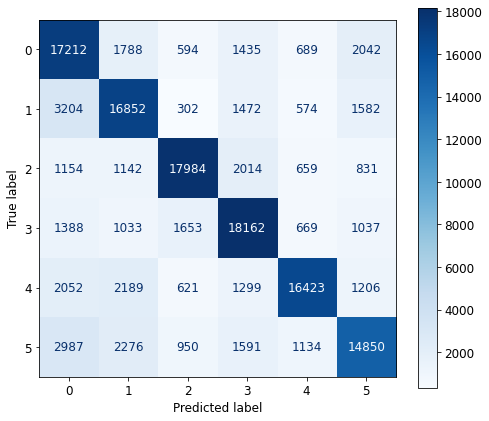

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
model=xgb_model.fit(X_train,y_train)
pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)
print(classification_report(y_test,pred))


### The best results were concluded using the **Random Forest Classifier** and **Decision Tree Algorithm** .
The **highest accuracy of 98% with  precision 0.98 ,recall 0.98and F1-score 0.98** was observed